In [30]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import traceback
import numpy as np
import pandas as pd
import datetime as dt


In [3]:
df = pd.read_csv('AirPassengers.csv')

In [4]:
df = df[['Timeline','Number_of_Passengers']]

In [5]:
df

,Timeline,Number_of_Passengers
0,01-01-1949,112.0
1,01-02-1949,118.0
2,01-03-1949,132.0
3,01-04-1949,129.0
4,01-05-1949,121.0
...,...,...
139,01-08-1960,606.0
140,01-09-1960,508.0
141,01-10-1960,461.0
142,01-11-1960,390.0


In [6]:
df["Timeline"] = pd.to_datetime(df["Timeline"],format="%d-%m-%Y").dt.floor('D')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Timeline              144 non-null    datetime64[ns]
 1   Number_of_Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [8]:
df.set_index('Timeline',inplace=True)

* ETS Decomposition : Divides the series into its principal components i.e. Trend, Seasonality and Residual
* Hodrick-Prescott Filter : Divides the series into Trend and Cycle
* ADF and KPSS test : Stationarity check
* Kruskal-Wallis test : Determines if the series is seasonal
* Mann-Kendall test : Determines if the series has trend (non-seasonal/seasonal trend)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

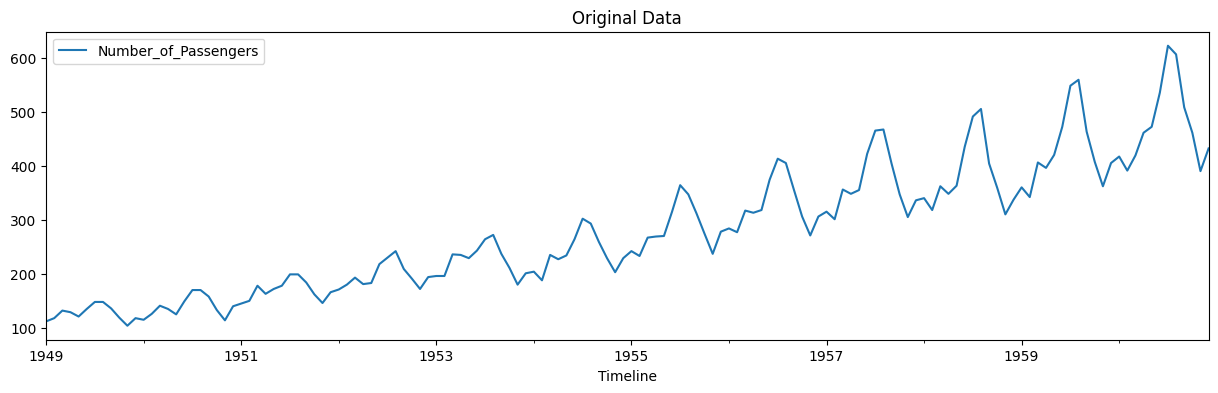

In [41]:
df.plot(figsize=(15,4))
plt.title('Original Data')
plt.show()

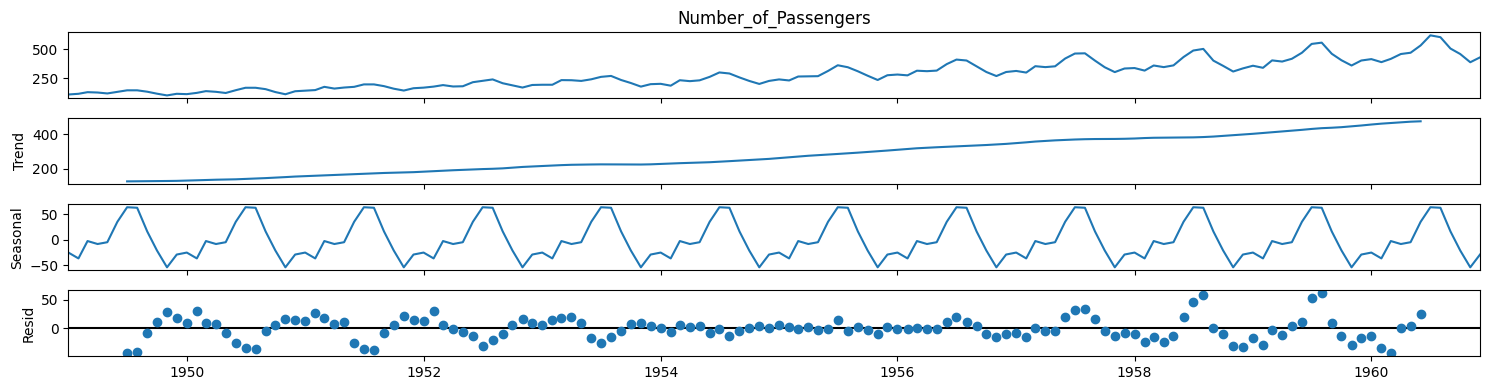

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
air_decom = seasonal_decompose(df['Number_of_Passengers'],model='additive',period=12)
air_decom.plot()
plt.show()

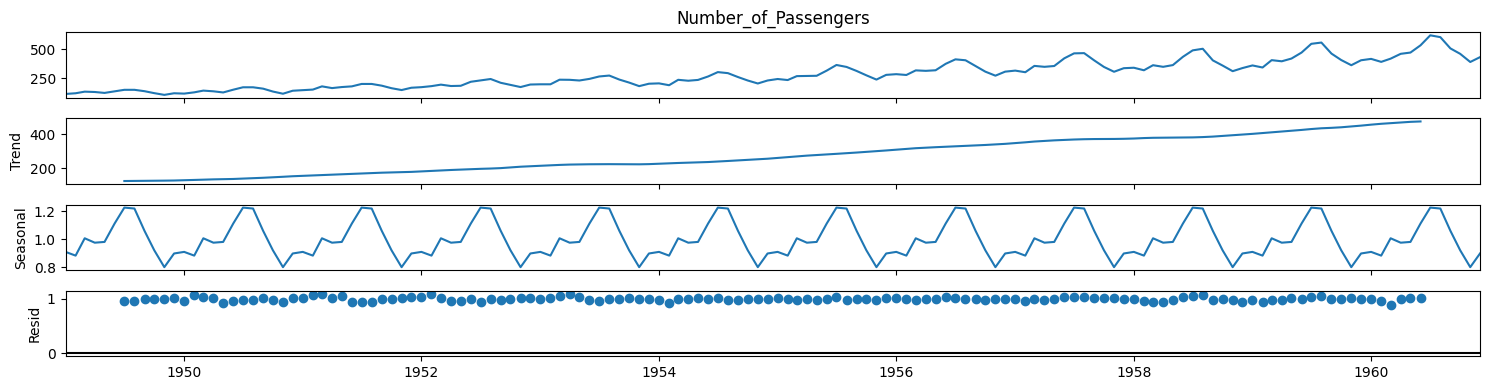

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
air_decom = seasonal_decompose(df['Number_of_Passengers'],model='multiplicative',period=12)
air_decom.plot()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
def ADF_test (series):    
    adf = adfuller(series)
    print('ADF Test Result')
    print("Test statistic: {}".format (adf[0])) 
    print("p-value: {}".format (adf[1]))
    print ("Critical values : ")
    for key, value in adf[4].items():
        print("{} : {}".format(key, value))
    if (adf[1] <= 0.05):
        print('Reject the null hypothesis')
        print('Series is Stationary')
    else:
        print('Failed to reject the null hypothesis')
        print('Series is Non-Stationary')

In [14]:
ADF_test(df)

ADF Test Result
Test statistic: 0.8153688792060547
p-value: 0.9918802434376411
Critical values : 
1% : -3.4816817173418295
5% : -2.8840418343195267
10% : -2.578770059171598
Failed to reject the null hypothesis
Series is Non-Stationary


In [15]:
from statsmodels.tsa.stattools import kpss
def KPSS_test (series):
    print ("KPSS Test Result")
    kpss_test = kpss(series, regression='ct')
    print("Test statistic: {}".format (kpss_test[0])) 
    print("p-value: {}".format (kpss_test[1]))
    print ("Critical values :")
    for key, value in kpss_test[3].items():
        print("{} : {}".format(key, value))                             
    if(kpss_test[1] < 0.05):
        print('Series is Non-Stationary')
    else:
        print('Series is Stationary')

In [31]:
KPSS_test(df)

KPSS Test Result
Test statistic: 0.09614984853532524
p-value: 0.1
Critical values :
10% : 0.119
5% : 0.146
2.5% : 0.176
1% : 0.216
Series is Stationary


As KPSS test result stationarity and ADF Test result non-stationarity so trend has to be removed as the data has trend stationary

In [17]:
from statsmodels.tsa.filters.hp_filter import hpfilter
def hodrick_prescott(series, lamb):
    df = series.to_frame()
    cycle, trend = hpfilter(series, lamb= lamb)
    df['cycle'], df['trend'] = cycle, trend
    return df

In [38]:
res = hodrick_prescott(df['Number_of_Passengers'], lamb=129600) #Common choices are 1600 for quarterly data, 6.25 for annual data, and 129600 for monthly data

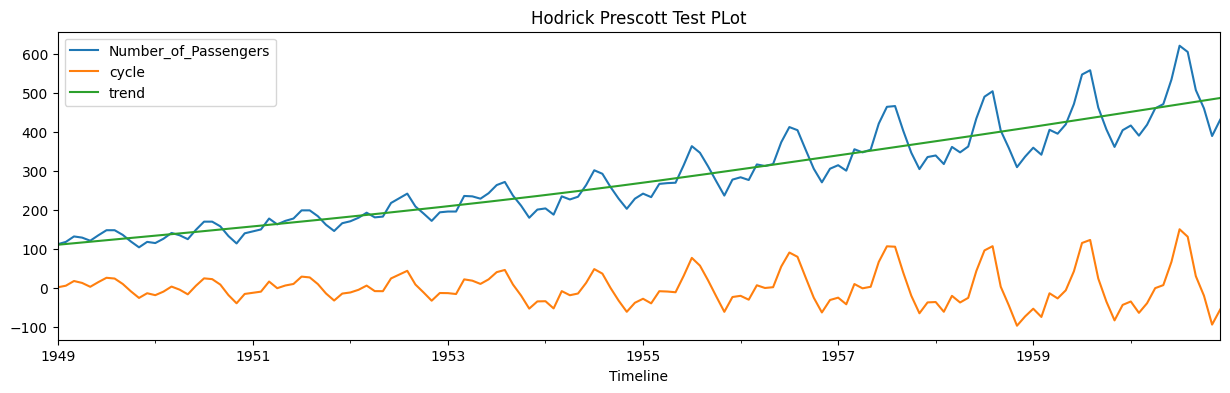

In [42]:
res.plot()
plt.title('Hodrick Prescott Test PLot')
plt.show()

Clearly we see an upward trend presented within data also we can see the cyclic component of the time series

In [18]:
from scipy.stats import kruskal
def seasonality_test(series):
    seasonal = 0
    idx = np.arange(len(series.index)) % 12
    H_statistic, p_value = kruskal(series, idx)
    if p_value <= 0.05:
        seasonal = 1
        return {"RESPONSE": "success",
                "data": (seasonal, "The series has seasonality")
                }
    return {"RESPONSE": "success",
            "data": (seasonal, "No seasonality found in the series")
            }

In [19]:
resp = seasonality_test(df['Number_of_Passengers'])
resp

{'RESPONSE': 'success', 'data': (1, 'The series has seasonality')}

In [33]:
import pymannkendall as mk
def MK_Test(series, seasonal):
    if seasonal == False:
        data_mk = mk.original_test(series)
        trend = data_mk[0]
        p_value = data_mk[2]
    else:
        data_mk_seasonal_test = mk.seasonal_test(series, period= 12)
        trend = data_mk_seasonal_test[0]
        p_value = data_mk_seasonal_test[2]
    
    if trend == 'decreasing' or trend == 'increasing':
        trend = 'Present'
        return p_value, trend
    return p_value, trend

In [37]:
seasonal = True #from previous test
p_value, trend = MK_Test(df['Number_of_Passengers'], seasonal)
print("MK Test Result ->")
print("p_value: {} & trend: {}".format(p_value, trend))

MK Test Result ->
p_value: 0.0 & trend: Present


Since in the above example, the p-value is 0.0 which is less than the threshold(0.5) which is the alpha(0.5) then we fail not to reject the accepted hypothesis i.e. we do have sufficient evidence to say that sample has a trend present.